In [ ]:
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from ev2gym_driveway.models.ev2gym_driveway_env import EV2GymDriveway
from ev2gym_driveway.rl_agent.state import state_function_basic_profit_view
from ev2gym_driveway.rl_agent.reward import reward_function_profit_only

In [ ]:
# Training a PPO agent in EV2Gym Driveway environment

PROJECT_DIR = Path().resolve()
CONFIG_PATH = PROJECT_DIR / "ev2gym_driveway" / "example_config_files" / "3_houses_no_inflexible_loads.yaml"

def make_env(save_statistics= False):
    return EV2GymDriveway(
        config_file=CONFIG_PATH,
        state_function=state_function_basic_profit_view,
        reward_function=reward_function_profit_only,
        verbose=True,  # so print_statistics works at the end
        save_statistics=save_statistics
    )

# Wrap in DummyVecEnv for SB3
env = DummyVecEnv([make_env])

# Create and train PPO agent
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log="./ev2gym_logs/",  # optional
    n_steps=2048,
    batch_size=64,
    learning_rate=3e-4
)

model.learn(total_timesteps=100_000)

# Save the model
model.save("ppo_ev2gym_agent")


Initializing EV2Gym environment...
Using cpu device
Logging to ./ev2gym_logs/PPO_12
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [0.62227595]
CS 2 normalized actions: [-0.31759447]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [0.33749622]
CS 2 normalized actions: [0.82949167]
--------------------------------------------------------------------------------
CS 0 normalized actions: [0.19911875]
CS 1 normalized actions: [0.4568961]
CS 2 normalized actions: [0.68055487]
--------------------------------------------------------------------------------
CS 0 normalized actions: [0.76876158]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [-1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [-0.98551017]
CS 1 normalized actions: [-0.47781649]
CS 2 nor

In [ ]:
# Charge as Fast As Possible
from ev2gym_driveway.baselines.heuristics import ChargeAsFastAsPossible

PROJECT_DIR = Path().resolve()
CONFIG_PATH = PROJECT_DIR / "ev2gym_driveway" / "example_config_files" / "3_houses_no_inflexible_loads.yaml"

# Initialize the environment
env = EV2GymDriveway(
        config_file=CONFIG_PATH,
        state_function=state_function_basic_profit_view,
        reward_function=reward_function_profit_only,
        verbose=True,  # so print_statistics works at the end
        save_statistics=True,
    )
obs = env.reset()
env._save_ev_profiles("saved_ev_profiles/ev_profiles_3_houses.pkl")

# Create Agents
agent = ChargeAsFastAsPossible()  # heuristic

for t in range(env.simulation_length):
    actions = agent.get_action(env)  # get action from the agent/ algorithm
    new_state, reward, done, truncated, stats = env.step(actions)

Initializing EV2Gym environment...
[INFO] EV weekly profiles saved to saved_ev_profiles/ev_profiles_3_houses.pkl
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
--------------------------------------------------------------------------------
CS 0 normalized actions: [1.]
CS 1 normalized actions: [1.]
CS 2 normalized actions: [1.]
--------------------------------

In [16]:
# Running the trained PPO agent
# 1. Load trained model
model = PPO.load("ppo_ev2gym_agent")

# 2. Setup test env (we’ll access the raw env later)
PROJECT_DIR = Path().resolve()
CONFIG_PATH = PROJECT_DIR / "ev2gym_driveway" / "example_config_files" / "3_houses_no_inflexible_loads.yaml"

def make_env(save_statistics= True):
    return EV2GymDriveway(
        config_file=CONFIG_PATH,
        state_function=state_function_basic_profit_view,
        reward_function=reward_function_profit_only,
        verbose=True,  # so print_statistics works at the end
        save_statistics=save_statistics,
        load_ev_profiles_path=Path("saved_ev_profiles/ev_profiles_3_houses.pkl"),
    )

env_vec = DummyVecEnv([make_env])
env = env_vec.envs[0]  # unwrap raw environment for print_statistics()

# 3. Run one episode
obs = env_vec.reset()
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env_vec.step(action)
    done = done[0]  # unpack from vectorized env


Initializing EV2Gym environment...
[INFO] Loading saved EV weekly profiles from saved_ev_profiles/ev_profiles_3_houses.pkl
[INFO] Loading saved EV weekly profiles from saved_ev_profiles/ev_profiles_3_houses.pkl
--------------------------------------------------------------------------------
CS 0 normalized actions: [-0.22867562]
CS 1 normalized actions: [0.13961324]
CS 2 normalized actions: [0.10712554]
--------------------------------------------------------------------------------
CS 0 normalized actions: [-0.22758383]
CS 1 normalized actions: [0.13784418]
CS 2 normalized actions: [0.10593469]
--------------------------------------------------------------------------------
CS 0 normalized actions: [-0.22591533]
CS 1 normalized actions: [0.13566598]
CS 2 normalized actions: [0.10452436]
--------------------------------------------------------------------------------
CS 0 normalized actions: [-0.22366974]
CS 1 normalized actions: [0.13309814]
CS 2 normalized actions: [0.10289849]
-----

In [12]:
# Load in statistics
import pickle
from dataclasses import fields
import matplotlib.pyplot as plt
import numpy as np

def load_stats(file_name: str):
    with open(file_name, "rb") as f:
        loaded_stats = pickle.load(f)

    for field in fields(loaded_stats):
        name = field.name
        value = getattr(loaded_stats, name)
        print(f"{name}: {value.shape}")
    
    return loaded_stats

In [18]:
CAFAP_Stats = load_stats("statistics/3_houses_no_inflexible_loads_CAFAP.pkl")
PPO_Stats = load_stats("statistics/3_houses_no_inflexible_loads_PPO.pkl")

# loaded_stats2 = load_stats("statistics/sim_2025_04_27_819135.pkl")
# inflexible_loads2 = loaded_stats2.tr_inflexible_loads

# inflexible_loads1 == inflexible_loads2

cs_power_usage: (3, 672)
cs_current: (3, 672)
tr_inflexible_loads: (1, 672)
tr_overload: (1, 672)
money_spent_at_each_step: (3, 672)
money_earned_at_each_step: (3, 672)
cs_power_usage: (3, 672)
cs_current: (3, 672)
tr_inflexible_loads: (1, 672)
tr_overload: (1, 672)
money_spent_at_each_step: (3, 672)
money_earned_at_each_step: (3, 672)


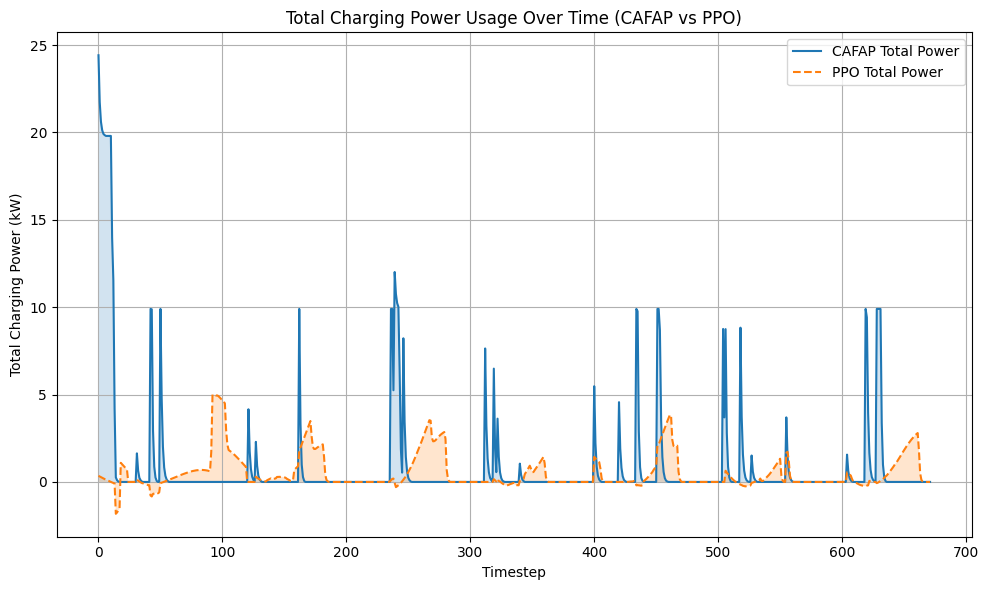

CAFAP Std Dev: 3.28510343860949
PPO Std Dev: 1.0304018689335663
CAFAP Peak-to-Average Ratio: 25.52168798015548
PPO Peak-to-Average Ratio: 9.478232964256929


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

timesteps = np.arange(CAFAP_Stats.cs_power_usage.shape[1])

# Sum across the EVs to get total charging power
CAFAP_total_power = np.sum(CAFAP_Stats.cs_power_usage, axis=0)
PPO_total_power = np.sum(PPO_Stats.cs_power_usage, axis=0)

plt.figure(figsize=(10,6))

plt.plot(timesteps, CAFAP_total_power, label="CAFAP Total Power", linestyle="-")
plt.plot(timesteps, PPO_total_power, label="PPO Total Power", linestyle="--")

plt.xlabel("Timestep")
plt.ylabel("Total Charging Power (kW)")
plt.title("Total Charging Power Usage Over Time (CAFAP vs PPO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.fill_between(timesteps, CAFAP_total_power, alpha=0.2)
plt.fill_between(timesteps, PPO_total_power, alpha=0.2)
plt.show()

print("CAFAP Std Dev:", np.std(CAFAP_total_power))
print("PPO Std Dev:", np.std(PPO_total_power))

print("CAFAP Peak-to-Average Ratio:", np.max(CAFAP_total_power)/np.mean(CAFAP_total_power))
print("PPO Peak-to-Average Ratio:", np.max(PPO_total_power)/np.mean(PPO_total_power))

print("CAFAP money spent": ))



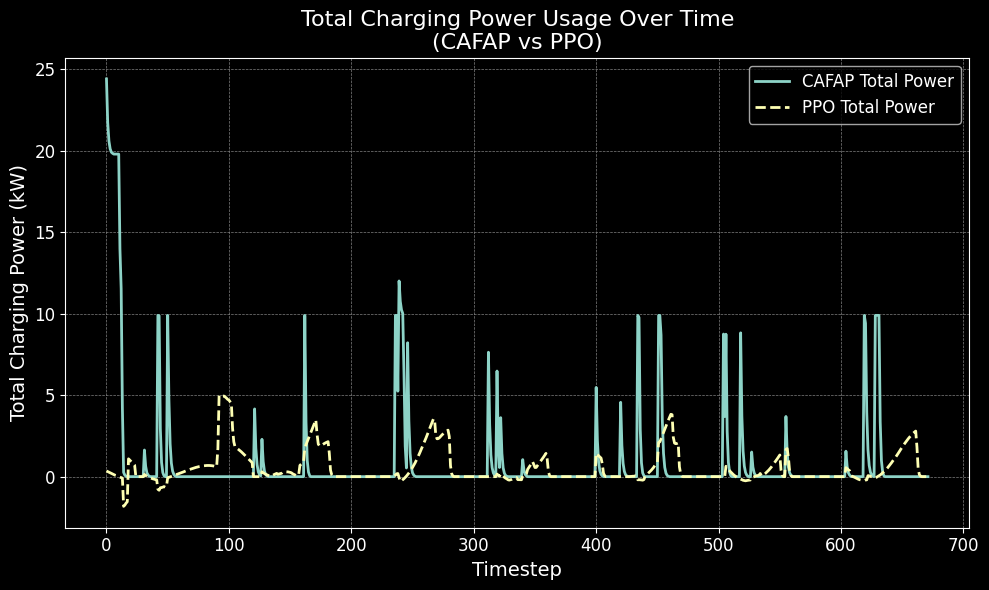

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming CAFAP_total_power and PPO_total_power are defined

timesteps = np.arange(CAFAP_total_power.shape[0])

plt.style.use('dark_background')  # <<< KEY: dark background

plt.figure(figsize=(10,6))

plt.plot(timesteps, CAFAP_total_power, label="CAFAP Total Power", linestyle="-", linewidth=2)
plt.plot(timesteps, PPO_total_power, label="PPO Total Power", linestyle="--", linewidth=2)

plt.xlabel("Timestep", fontsize=14)
plt.ylabel("Total Charging Power (kW)", fontsize=14)
plt.title("Total Charging Power Usage Over Time\n(CAFAP vs PPO)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

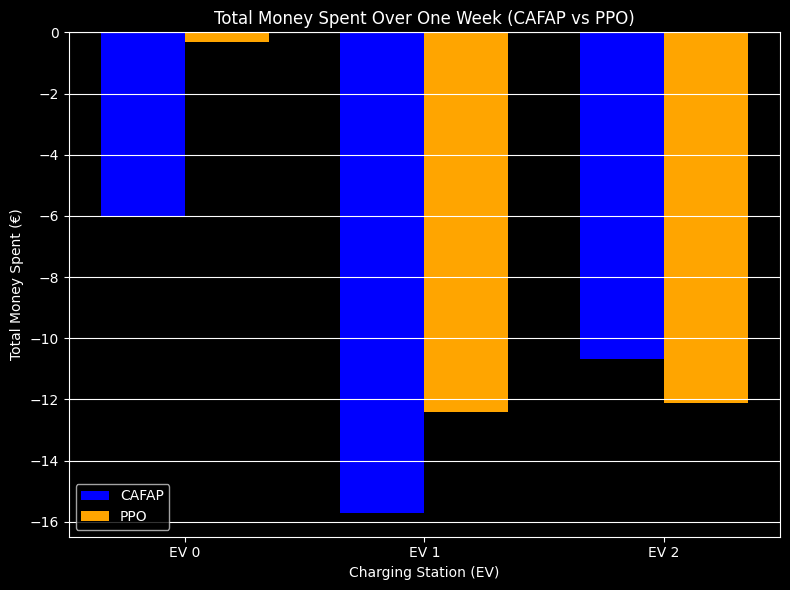

In [25]:
# Sum across timesteps
CAFAP_money_spent = np.sum(CAFAP_Stats.money_spent_at_each_step, axis=1)  # shape (3,)
PPO_money_spent = np.sum(PPO_Stats.money_spent_at_each_step, axis=1)      # shape (3,)

import numpy as np
import matplotlib.pyplot as plt

ev_ids = np.arange(len(CAFAP_money_spent))  # [0,1,2]

bar_width = 0.35

plt.figure(figsize=(8,6))

plt.bar(ev_ids - bar_width/2, CAFAP_money_spent, width=bar_width, label="CAFAP", color="blue")
plt.bar(ev_ids + bar_width/2, PPO_money_spent, width=bar_width, label="PPO", color="orange")

plt.xlabel("Charging Station (EV)")
plt.ylabel("Total Money Spent (€)")
plt.title("Total Money Spent Over One Week (CAFAP vs PPO)")
plt.xticks(ev_ids, [f"EV {i}" for i in ev_ids])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



In [26]:
CAFAP_money_spent  # shape (3,)
PPO_money_spent    # shape (3,)
total_cafap_spent = np.sum(CAFAP_money_spent)
total_ppo_spent = np.sum(PPO_money_spent)
# PPO is better if it spends *less* money
percent_savings = (total_cafap_spent - total_ppo_spent) / abs(total_cafap_spent) * 100

print(f"PPO reduces total cost by {percent_savings:.2f}% compared to CAFAP")


PPO reduces total cost by -23.44% compared to CAFAP


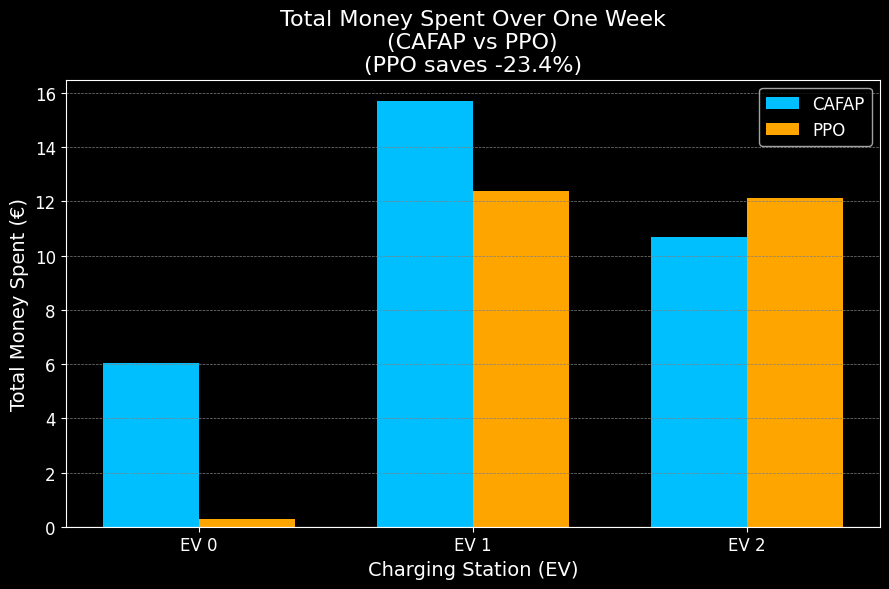

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming CAFAP_money_spent and PPO_money_spent are given

ev_ids = np.arange(len(CAFAP_money_spent))  # [0,1,2]
bar_width = 0.35

total_cafap_spent = np.sum(CAFAP_money_spent)
total_ppo_spent = np.sum(PPO_money_spent)
percent_savings = (total_cafap_spent - total_ppo_spent) / abs(total_cafap_spent) * 100

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(9,6))

bars1 = ax.bar(ev_ids - bar_width/2, -CAFAP_money_spent, width=bar_width, label="CAFAP", color="#00BFFF")  # deepskyblue
bars2 = ax.bar(ev_ids + bar_width/2, -PPO_money_spent, width=bar_width, label="PPO", color="#FFA500")      # orange

ax.axhline(0, color='white', linewidth=0.8)

ax.set_xlabel("Charging Station (EV)", fontsize=14)
ax.set_ylabel("Total Money Spent (€)", fontsize=14)
ax.set_title(f"Total Money Spent Over One Week\n(CAFAP vs PPO)\n(PPO saves {percent_savings:.1f}%)", fontsize=16)
ax.set_xticks(ev_ids)
ax.set_xticklabels([f"EV {i}" for i in ev_ids], fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
